In [1]:
import math
import gmsh
import numpy as np
from scipy.sparse import lil_matrix
from matspy import spy
from scipy.sparse.linalg import eigs, spsolve
import matplotlib.pyplot as plt
from collections import defaultdict

### Create the Mesh using GMSH

In [2]:
# Meshing density control
lc = 0.05

gmsh.initialize()

# Define rectangle surface
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(3, 0, 0, lc, 2)
gmsh.model.geo.addPoint(3, 0.5, 0, lc, 3)
gmsh.model.geo.addPoint(0, 0.5, 0, lc, 4)
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(3, 2, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)
gmsh.model.geo.addCurveLoop([4, 1, -2, 3], 1)
gmsh.model.geo.addPlaneSurface([1], 1)

# Extrude Rectangle
ov2 = gmsh.model.geo.extrude([(2, 1)], 0, 0, 0.75)

# Generate Mesh
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(3)

#gmsh.fltk.run()

### View Mesh

In [3]:
gmsh.fltk.run()

### Local Matrix Generation Functions

#### 3D Case

In [4]:
LOCAL_EDGE_NODES_3D = np.array([[1, 2],
                                [1, 3],
                                [1, 4],
                                [2, 3],
                                [2, 4],
                                [3, 4]])

""" 
Coordinates are expected in this form:
[[x1 y1 z1],
 [x2 y2 z2],
 [x3 y3 z3],
 [x4 y4 z4]]
"""

"""
Simplex coefficients are expected in this form:
[[b1 c1 d1 a1],
 [b2 c2 d2 a2],
 [b3 c3 d3 a3],
 [b4 c4 d4 a4]]
"""

def get_volume(coordinates):
    mat = np.hstack((np.ones((4, 1)), coordinates))
    return np.abs(np.linalg.det(mat)/6)

def get_simplex_coefficients_3d(coordinates):
    mat = coordinates.T
    mat = np.vstack([mat, [1,1,1,1]])
    return np.linalg.inv(mat)

def v_3d(i, j, simplex_coefficients):
    return np.cross(simplex_coefficients[i-1][:3], simplex_coefficients[j-1][:3])

def phi_3d(i, j, simplex_coefficients):
    return np.dot(simplex_coefficients[i-1][:3], simplex_coefficients[j-1][:3])

M_3d = np.array([[2, 1, 1, 1],
                 [1, 2, 1, 1],
                 [1, 1, 2, 1],
                 [1, 1, 1, 2]]) / 20

def S_and_T_3d(coordinates):
    S = np.zeros((6,6), dtype="complex")
    T = np.zeros((6,6), dtype="complex")
    volume = get_volume(coordinates)
    simplex_coefficients = get_simplex_coefficients_3d(coordinates)
    for ii in range(0,6):
        for jj in range(0,6):
            i1 = LOCAL_EDGE_NODES_3D[ii,0];
            i2 = LOCAL_EDGE_NODES_3D[ii,1];
            j1 = LOCAL_EDGE_NODES_3D[jj,0];
            j2 = LOCAL_EDGE_NODES_3D[jj,1];
            S[ii,jj] = 4*volume*np.dot(v_3d(i1,i2, simplex_coefficients), v_3d(j1,j2, simplex_coefficients))
            T[ii,jj] = volume*(phi_3d(i2, j2, simplex_coefficients)*M_3d[i1-1, j1-1] - 
                               phi_3d(i2, j1, simplex_coefficients)*M_3d[i1-1, j2-1] - 
                               phi_3d(i1, j2, simplex_coefficients)*M_3d[i2-1, j1-1] + 
                               phi_3d(i1, j1, simplex_coefficients)*M_3d[i2-1, j2-1])
    return S, T


#### 3D Case for Diagonally Anistropic Materials

In [5]:
def phi_3d_Diag_Anistropic(i, j, simplex_coefficients, vec):
    return np.dot(simplex_coefficients[i-1][:3], vec*simplex_coefficients[j-1][:3])

def S_and_T_3d_Diag_Anistropic(coordinates, s_vec, t_vec):
    S = np.zeros((6,6), dtype="complex")
    T = np.zeros((6,6), dtype="complex")
    volume = get_volume(coordinates)
    simplex_coefficients = get_simplex_coefficients_3d(coordinates)
    for ii in range(0,6):
        for jj in range(0,6):
            i1 = LOCAL_EDGE_NODES_3D[ii,0];
            i2 = LOCAL_EDGE_NODES_3D[ii,1];
            j1 = LOCAL_EDGE_NODES_3D[jj,0];
            j2 = LOCAL_EDGE_NODES_3D[jj,1];
            S[ii,jj] = 4*volume*np.dot(v_3d(i1,i2, simplex_coefficients), s_vec*v_3d(j1,j2, simplex_coefficients))
            T[ii,jj] = volume*(phi_3d_Diag_Anistropic(i2, j2, simplex_coefficients, t_vec)*M_3d[i1-1, j1-1] - 
                               phi_3d_Diag_Anistropic(i2, j1, simplex_coefficients, t_vec)*M_3d[i1-1, j2-1] - 
                               phi_3d_Diag_Anistropic(i1, j2, simplex_coefficients, t_vec)*M_3d[i2-1, j1-1] + 
                               phi_3d_Diag_Anistropic(i1, j1, simplex_coefficients, t_vec)*M_3d[i2-1, j2-1])
    return S, T

#### 2D Case

In [6]:
LOCAL_EDGE_NODES_2D = np.array([[1, 2],
                                [1, 3],
                                [2, 3]])

""" 
Coordinates are expected in this form:
[[x1 y1],
 [x2 y2],
 [x3 y3]]
"""

"""
Simplex coefficients are expected in this form:
[[b1 c1 a1],
 [b2 c2 a2],
 [b3 c3 a3]]
"""

def get_area(coordinates):
    mat = np.hstack((np.ones((3, 1)), coordinates))
    return np.abs(np.linalg.det(mat)/2)

def get_simplex_coefficients_2d(coordinates):
    mat = coordinates.T
    mat = np.vstack([mat, [1,1,1]])
    return np.linalg.inv(mat)

def v_2d(i, j, simplex_coefficients):
    b_i = simplex_coefficients[i-1][0]
    b_j = simplex_coefficients[j-1][0]
    c_i = simplex_coefficients[i-1][1]
    c_j = simplex_coefficients[j-1][1]
    return b_i*c_j - b_j*c_i

def phi_2d(i, j, simplex_coefficients):
    return np.dot(simplex_coefficients[i-1][:2], simplex_coefficients[j-1][:2])

M = np.array([[2, 1, 1],
              [1, 2, 1],
              [1, 1, 2]]) / 12

def S_and_T_2d(coordinates):
    S = np.zeros((3,3), dtype="complex")
    T = np.zeros((3,3), dtype="complex")
    area = get_area(coordinates)
    simplex_coefficients = get_simplex_coefficients_2d(coordinates)
    for ii in range(0,3):
        for jj in range(0,3):
            i1 = LOCAL_EDGE_NODES_2D[ii,0];
            i2 = LOCAL_EDGE_NODES_2D[ii,1];
            j1 = LOCAL_EDGE_NODES_2D[jj,0];
            j2 = LOCAL_EDGE_NODES_2D[jj,1];
            S[ii,jj] = 4*area*v_2d(i1,i2, simplex_coefficients)*v_2d(j1,j2, simplex_coefficients)
            T[ii,jj] = area*(phi_2d(i2, j2, simplex_coefficients)*M[i1-1, j1-1] - 
                             phi_2d(i2, j1, simplex_coefficients)*M[i1-1, j2-1] - 
                             phi_2d(i1, j2, simplex_coefficients)*M[i2-1, j1-1] + 
                             phi_2d(i1, j1, simplex_coefficients)*M[i2-1, j2-1])
    return S, T


#### PML Coefficients

Generates anistropic permitivity and permeability elements of a perfectly matched layer. From _"A Perfectly Matched Anisotropic Absorber 
for Use as an Absorbing Boundary Condition"_ by Zachary S. Sacks, David M. Kingsland, Robert Lee, and Jin-Fa Lee

In [7]:
def PML(alpha, beta, incident_axis):
    P = (alpha - 1j*beta) * np.ones((3), dtype="complex")
    P[incident_axis] = (alpha + 1j*beta) / (alpha**2 + beta**2)
    return P

### Plotting Functions

### Peform Mesh Bookeeping

In [8]:
def create_lookup_table(nodeTags):
    nodeTagsMap = -1 * np.ones(nodeTags.max(), dtype="int")
    for i, node in enumerate(nodeTags):
        nodeTagsMap[int(node-1)] = i
    return nodeTagsMap

In [9]:
nodeTags, nodeCoords, _ = gmsh.model.mesh.getNodes(dim=3, includeBoundary=True)
elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(3)
gmsh.model.mesh.createEdges()
edgeTags, _ = gmsh.model.mesh.getAllEdges()
elemTags = elemTags[0]
num_edges = len(edgeTags)

# Reshape coordinates and node tags.
nodeCoords = np.reshape(nodeCoords, (-1, 3))
elemNodeTags = np.reshape(elemNodeTags, (-1, 4))

elemNodeTags.sort(axis=1)

# Create a datastructure to lookup index of a given node.
nodeTagsMap = create_lookup_table(nodeTags)
elemTagsMap = create_lookup_table(elemTags)

### Misc Helper Functions

In [10]:
def get_global_edge_2d(j, nodes):
    local_edge_nodes_j = LOCAL_EDGE_NODES_2D[j];
    global_edge_nodes_j = nodes[local_edge_nodes_j-1]
    jj, _ = gmsh.model.mesh.getEdges(global_edge_nodes_j)
    jj = int(jj[0])

    return jj, global_edge_nodes_j

In [11]:
def get_global_edge_3d(j, nodes):
    local_edge_nodes_j = LOCAL_EDGE_NODES_3D[j];
    global_edge_nodes_j = nodes[local_edge_nodes_j-1]
    jj, _ = gmsh.model.mesh.getEdges(global_edge_nodes_j)
    jj = int(jj[0])

    return jj, global_edge_nodes_j

In [12]:
def get_elem_coords_2d(nodes, nodeTagsMap, nodeCoords):
    coords = np.zeros((3,3))
    for i, node in enumerate(nodes):
        node_index = int(nodeTagsMap[int(node-1)])
        coords[i] = nodeCoords[node_index]

    return coords

In [13]:
def get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords):
    coords = np.zeros((4,3))
    for i, node in enumerate(nodes):
        node_index = int(nodeTagsMap[int(node-1)])
        coords[i] = nodeCoords[node_index]

    return coords

### Plotting Functions

In [14]:
''''
simplex_coords form:
[lambda_1, lambda_2, lambda_3, lambda_4]
'''
def witney(i, j, simplex_coeff, simplex_coords):
    return simplex_coords[i-1]*simplex_coeff[j-1][:3] - simplex_coords[j-1]*simplex_coeff[i-1][:3]

def eval_vec(x, y, z, nodeTagsMap, elemNodeTags, nodeCoords, data, edge_map, edge_include_mask, edge_exclude_mask):
    elementTag, _, _, _, _, _ = gmsh.model.mesh.getElementByCoordinates(x, y, z, 3, strict=True)
    nodes = elemNodeTags[elemTagsMap[int(elementTag-1)]]
    coords = get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords)
    simplex_coeff = get_simplex_coefficients_3d(coords)

    simplex_coords = simplex_coeff @ np.array([x,y,z,1])
    
    result = np.zeros(3, dtype="complex")
    for j in range(0,6):
        edge_nodes = LOCAL_EDGE_NODES_3D[j]
        jj, _ = get_global_edge_3d(j, nodes)
        is_j_excluded = edge_exclude_mask[jj - 1]
        is_j_included = edge_include_mask[jj - 1]
        if is_j_excluded:
            continue
        if not is_j_included:
            continue
        jj = edge_map[jj - 1]
        result = result + data[jj] * witney(edge_nodes[0], edge_nodes[1], simplex_coeff, simplex_coords)
        
    return result

'''
axes: ("XY")
steps: (20, 20)
span: ((0,1), (0,0.5))
level: 0.3
'''
def eval_vector_plane(axes, steps, span, level, data, edge_map, nodeTagsMap, elemNodeTags, nodeCoords, edge_include_mask, edge_exclude_mask):

    results = np.zeros((steps[0], steps[1], 3),dtype="complex")

    X = np.zeros((steps[0] * steps[1]))
    Y = np.zeros((steps[0] * steps[1]))
    U = np.zeros((steps[0] * steps[1]), dtype="complex")
    V = np.zeros((steps[0] * steps[1]), dtype="complex")

    for i, x in enumerate(np.linspace(span[0][0], span[0][1], steps[0])):
        for j, y in enumerate(np.linspace(span[1][0], span[1][1], steps[1])):
            if axes == "XY":
                results[i, j] = eval_vec(x, y, level, nodeTagsMap, elemNodeTags, nodeCoords, data, edge_map, edge_include_mask, edge_exclude_mask)
            elif axes == "XZ":
                results[i, j] = eval_vec(x, level, y, nodeTagsMap, elemNodeTags, nodeCoords, data, edge_map, edge_include_mask, edge_exclude_mask)
            elif axes == "YX":
                results[i, j] = eval_vec(y, x, level, nodeTagsMap, elemNodeTags, nodeCoords, data, edge_map, edge_include_mask, edge_exclude_mask)
            elif axes == "YZ":
                results[i, j] = eval_vec(level, x, y, nodeTagsMap, elemNodeTags, nodeCoords, data, edge_map, edge_include_mask, edge_exclude_mask)
            elif axes == "ZX":
                results[i, j] = eval_vec(y, level, x, nodeTagsMap, elemNodeTags, nodeCoords, data, edge_map, edge_include_mask, edge_exclude_mask)
            elif axes == "ZY":
                results[i, j] = eval_vec(level, y, x, nodeTagsMap, elemNodeTags, nodeCoords, data, edge_map, edge_include_mask, edge_exclude_mask)
            else:
                print("Invalid Axes")
                exit(1)
             
            X[i + steps[1]*j] = x
            Y[i + steps[1]*j] = y

            if axes == "XY":
                U[i + steps[1]*j] = results[i, j][0]
                V[i + steps[1]*j] = results[i, j][1]
            elif axes == "XZ":
                U[i + steps[1]*j] = results[i, j][0]
                V[i + steps[1]*j] = results[i, j][2]
            elif axes == "YX":
                U[i + steps[1]*j] = results[i, j][1]
                V[i + steps[1]*j] = results[i, j][0]
            elif axes == "YZ":
                U[i + steps[1]*j] = results[i, j][1]
                V[i + steps[1]*j] = results[i, j][2]
            elif axes == "ZX":
                U[i + steps[1]*j] = results[i, j][2]
                V[i + steps[1]*j] = results[i, j][0]
            elif axes == "ZY":
                U[i + steps[1]*j] = results[i, j][2]
                V[i + steps[1]*j] = results[i, j][1]            

    return X, Y, U, V

### Solve Port Eigenfunctions

#### Find Elements on Port and Boundary

Port is on face where x=0

In [15]:
def both_nodes_are_port(nodes, nodeTagsMap, nodeCoords, tol=1e-3):
    node1_index = int(nodeTagsMap[int(nodes[0]-1)])
    node2_index = int(nodeTagsMap[int(nodes[1]-1)])

    coord1 = nodeCoords[node1_index]
    coord2 = nodeCoords[node2_index]

    if math.isclose(coord1[0], 0.0, abs_tol=tol) and math.isclose(coord2[0], 0.0, abs_tol=tol):
        return True

    return False        

Boundary is on edge of port

In [16]:
def both_nodes_are_port_boundary(nodes, nodeTagsMap, nodeCoords, tol=1e-3):
    node1_index = int(nodeTagsMap[int(nodes[0]-1)])
    node2_index = int(nodeTagsMap[int(nodes[1]-1)])

    coord1 = nodeCoords[node1_index]
    coord2 = nodeCoords[node2_index]
    
    if math.isclose(coord1[1], 0.0, abs_tol=tol) and math.isclose(coord2[1], 0.0, abs_tol=tol):
        return True
    if math.isclose(coord1[1], 0.5, abs_tol=tol) and math.isclose(coord2[1], 0.5, abs_tol=tol):
        return True
    if math.isclose(coord1[2], 0.0, abs_tol=tol) and math.isclose(coord2[2], 0.0, abs_tol=tol):
        return True
    if math.isclose(coord1[2], 0.75, abs_tol=tol) and math.isclose(coord2[2], 0.75, abs_tol=tol):
        return True

Find the elements

In [17]:
edge_is_port = np.zeros(num_edges, dtype='bool')
edge_is_port_boundary = np.zeros(num_edges, dtype='bool')
port_elements = defaultdict(set)

for e, (elem, nodes) in enumerate(zip(elemTags, elemNodeTags)):
    coords = get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords)

    for j in range(0,6):
        jj, global_edge_nodes_j = get_global_edge_3d(j, nodes)
        edge_is_port[jj - 1] = both_nodes_are_port(global_edge_nodes_j, nodeTagsMap, nodeCoords)        
        if (edge_is_port[jj - 1]):
            edge_is_port_boundary[jj - 1] = both_nodes_are_port_boundary(global_edge_nodes_j, nodeTagsMap, nodeCoords)
            port_elements[e].add(global_edge_nodes_j[0])
            port_elements[e].add(global_edge_nodes_j[1])

non_boundary_port_edges = edge_is_port.sum() - edge_is_port_boundary.sum()

modified_edge_port_map = -1 * np.ones(num_edges, dtype="int")
i = 0
for edge, (is_port_boundary, is_port) in enumerate(zip(edge_is_port_boundary, edge_is_port)):
    if not is_port_boundary and is_port:
        modified_edge_port_map[edge] = i
        i+=1

#### Assemble Port Matrix

In [18]:
# Loop through each element.
S = lil_matrix((non_boundary_port_edges,non_boundary_port_edges), dtype="complex")
T = lil_matrix((non_boundary_port_edges,non_boundary_port_edges), dtype="complex")
for elem, nodes in port_elements.items():
    nodes = list(nodes)
    nodes.sort()
    nodes = np.array(nodes)
    if (len(nodes) != 3):
        continue

    # Get coordinates in required form
    coords = get_elem_coords_2d(nodes, nodeTagsMap, nodeCoords)    
    coords = coords[:,1:]
    
    # Get local S and T matrices
    S_elem, T_elem = S_and_T_2d(coords)

    # Place local matrix elements in global matrix
    for j in range(0,3):
        jj, _ = get_global_edge_2d(j, nodes)
        is_j_boundary = edge_is_port_boundary[jj - 1]
        jj = modified_edge_port_map[jj - 1]
        
        for k in range(0,3):
            kk, _ = get_global_edge_2d(k, nodes)
            is_k_boundary = edge_is_port_boundary[kk - 1]
            kk = modified_edge_port_map[kk - 1]

            if not is_j_boundary and not is_k_boundary:
                
                S[jj, kk] = S[jj, kk] + S_elem[j, k]
                T[jj, kk] = T[jj, kk] + T_elem[j, k]

S = S.tocsr()
T = T.tocsr()

#### Inspect Structure of Port FEM Matrix

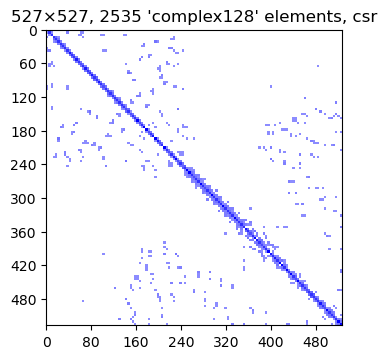

In [19]:
spy(S)

### Solve

In [20]:
mu_r = 1
e_r = 1

w, v = eigs(S / mu_r, k=10, M=e_r * T, sigma=49)

print(np.sqrt(w))
print(v.shape)

[7.55164144e+00-5.96084919e-16j 6.28345511e+00-1.64224549e-16j
 8.37845742e+00+4.87754028e-16j 4.18898591e+00-3.15766742e-16j
 1.26724585e-06-9.24387515e-09j 1.07654539e-06-2.76643098e-08j
 1.01869078e-06+1.83989294e-08j 8.98895941e-07-1.10480990e-07j
 9.27492392e-07-2.20323963e-08j 9.14784234e-07+7.41295715e-08j]
(527, 10)


#### Plot Port Excitation

Text(0, 0.5, 'Z')

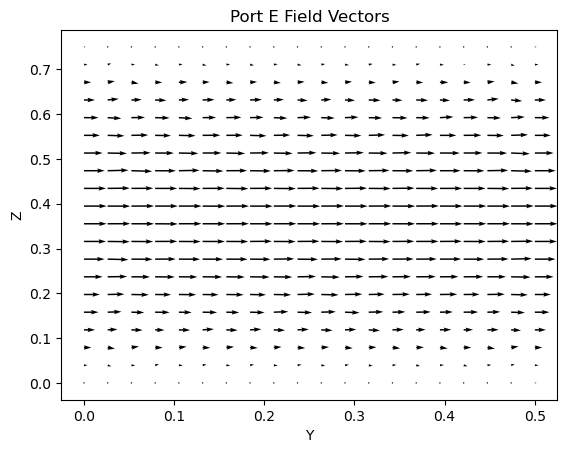

In [21]:
excitation_i = 3
excitation_vec = v[:,excitation_i]
excitation_k_2 = w[excitation_i]

X, Y, U, V = eval_vector_plane("YZ", (20,20), ((0, 0.5), (0, 0.75)), 0, excitation_vec, modified_edge_port_map, nodeTagsMap, elemNodeTags, nodeCoords, edge_is_port, edge_is_port_boundary)

plt.figure()
plt.quiver(X,Y,np.real(U),np.real(V))
plt.title("Port E Field Vectors")
plt.xlabel("Y")
plt.ylabel("Z")

### Solve Full Problem

Outside of box is boundary

In [22]:
def both_nodes_are_boundary(nodes, nodeTagsMap, nodeCoords, tol=1e-3):
    node1_index = int(nodeTagsMap[int(nodes[0]-1)])
    node2_index = int(nodeTagsMap[int(nodes[1]-1)])

    coord1 = nodeCoords[node1_index]
    coord2 = nodeCoords[node2_index]

    if math.isclose(coord1[0], 0.0, abs_tol=tol) and math.isclose(coord2[0], 0.0, abs_tol=tol):
        return True
    if math.isclose(coord1[0], 1.0, abs_tol=tol) and math.isclose(coord2[0], 1.0, abs_tol=tol):
        return True
    if math.isclose(coord1[1], 0.0, abs_tol=tol) and math.isclose(coord2[1], 0.0, abs_tol=tol):
        return True
    if math.isclose(coord1[1], 0.5, abs_tol=tol) and math.isclose(coord2[1], 0.5, abs_tol=tol):
        return True
    if math.isclose(coord1[2], 0.0, abs_tol=tol) and math.isclose(coord2[2], 0.0, abs_tol=tol):
        return True
    if math.isclose(coord1[2], 0.75, abs_tol=tol) and math.isclose(coord2[2], 0.75, abs_tol=tol):
        return True
    
    return False

Find boundary edges

In [23]:
edge_is_boundary = np.zeros(num_edges, dtype='bool')

for e, (elem, nodes) in enumerate(zip(elemTags, elemNodeTags)):
    # Get coordinates in required form
    coords = get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords)

    for j in range(0,6):
        jj, global_edge_nodes_j = get_global_edge_3d(j, nodes)
        edge_is_boundary[jj - 1] = both_nodes_are_boundary(global_edge_nodes_j, nodeTagsMap, nodeCoords)

non_boundary_edges = num_edges - edge_is_boundary.sum()

modified_edge_map = -1 * np.ones(num_edges, dtype="int")
i = 0
for edge, is_boundary in enumerate(edge_is_boundary):
    if not is_boundary:
        modified_edge_map[edge] = i
        i+=1

Define PML region and attenuation gradient

In [38]:
def PML_Region(x):
    alpha = 0
    if (x >= 2):
        alpha = np.exp(10*(x-2))
        return True, alpha
    return False, alpha

#### Assemble Full Matrix

In [39]:
# Loop through each element.
S = lil_matrix((non_boundary_edges,non_boundary_edges), dtype="complex")
T = lil_matrix((non_boundary_edges,non_boundary_edges), dtype="complex")
b = np.zeros(non_boundary_edges, dtype="complex")

for elem, nodes in zip(elemTags, elemNodeTags):
    # Get coordinates in required form
    coords = get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords)

    # Enforce PML if necessary
    centroid = np.mean(coords, axis=0)
    is_pml, alpha = PML_Region(centroid[0])

    # Get local S and T matrices
    if (is_pml):
        pml = PML(alpha, 5.5, 0)
        S_elem, T_elem = S_and_T_3d_Diag_Anistropic(coords, 1/pml, pml)
    else:
        S_elem, T_elem = S_and_T_3d(coords)

    # Place local matrix elements in global matrix
    for j in range(0,6):
        jj, _ = get_global_edge_3d(j, nodes)
        is_j_boundary = edge_is_boundary[jj - 1]
        is_j_port = edge_is_port[jj - 1]
        jj = modified_edge_map[jj - 1]
        
        for k in range(0,6):
            kk, _ = get_global_edge_3d(k, nodes)
            is_k_boundary = edge_is_boundary[kk - 1]
            is_k_port = edge_is_port[kk - 1]
            kk_save = kk
            kk = modified_edge_map[kk - 1]

            if not is_j_boundary and not is_k_boundary:                                
                S[jj, kk] = S[jj, kk] + S_elem[j, k]
                T[jj, kk] = T[jj, kk] + T_elem[j, k]

            elif not is_j_boundary and is_k_port:
                amplitude = excitation_vec[modified_edge_port_map[kk_save - 1]]
                b[jj] -= amplitude * S_elem[j, k]

S = S.tocsr()
T = T.tocsr()

#### Solve

In [40]:
k0 = 5.5
sol = spsolve(S / mu_r - k0**2 * e_r * T, b)

#### Plot Result

Text(0, 0.5, 'Y')

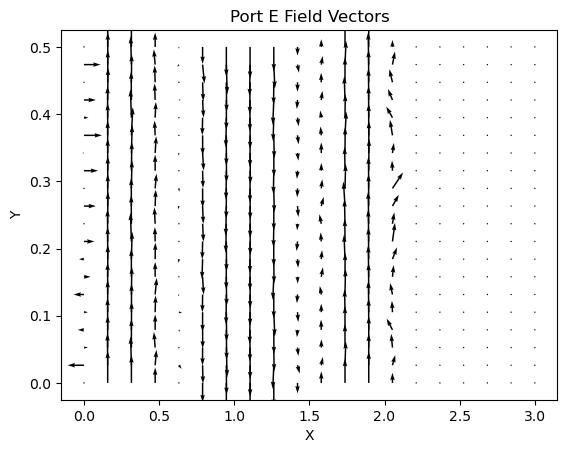

In [42]:
X, Y, U, V = eval_vector_plane("XY", (20,20), ((0, 3), (0, 0.5)), 0.35, sol, modified_edge_map, nodeTagsMap, elemNodeTags, nodeCoords, np.ones(num_edges, dtype="bool"), edge_is_boundary)
plt.figure()
plt.quiver(X,Y,np.real(U),np.real(V))
plt.title("Port E Field Vectors")
plt.xlabel("X")
plt.ylabel("Y")

In [28]:
#gmsh.finalize()